In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy.stats import levene, bartlett, wilcoxon

In [2]:
crabnet_abs = pd.read_csv('data_RO2/CrabNet_abs_only_predictions.csv')
crabnet_labels = pd.read_csv('data_RO2/CrabNet_labels_predictions.csv')
crabnet_full = pd.read_csv('data_RO2/CrabNet_full_predictions.csv')

xgb_abs = pd.read_csv('data_RO2/XGBoost_abs_only_predictions.csv')
xgb_labels = pd.read_csv('data_RO2/XGBoost_labels_predictions.csv')
xgb_full = pd.read_csv('data_RO2/XGBoost_full_predictions.csv')

gnn_abs = pd.read_csv('data_RO2/GNN_absorber_predictions.csv')
gnn_labels = pd.read_csv('data_RO2/GNN_labels_predictions.csv')
gnn_full = pd.read_csv('data_RO2/GNN_full_predictions.csv')


# #The following eliminations were made stepwise, when values were identified as outliers
# #very crazy prediction by gnn_labels
indices_to_remove = []
# indices_to_remove.append(gnn_labels[gnn_labels['predicted'] < -20].index[0])
# #
# # outliers: error over 12
# indices_to_remove.append(132) # crabnet baseline predicts bad here
# #all three crabnet models predict very wrong on these two:
# indices_to_remove.append(511) # actually index 510, but need to increase 2
# indices_to_remove.append(540) # actually index 539, but need to increase 1
# indices_to_remove.append(114) # very bad disagreement-outlier for gnn & xgboost
# indices_to_remove.append(390) # very bad disagreement-outlier for xgboost full & baseline
# indices_to_remove.append(304) # very bad disagreement-outlier for xgboost full & baseline


print(len(gnn_abs))
for index_rm in indices_to_remove:
    # the gnn_labels messes up one prediction, so in order to maintain pairs,
    # this data point needs to be excluded from all predictions
    gnn_abs = gnn_abs.drop(index=index_rm)
    gnn_labels = gnn_labels.drop(index=index_rm)
    gnn_full = gnn_full.drop(index=index_rm)
    xgb_abs = xgb_abs.drop(index=index_rm)
    xgb_full = xgb_full.drop(index=index_rm)
    xgb_labels = xgb_labels.drop(index=index_rm)
    crabnet_abs = crabnet_abs.drop(index=index_rm)
    crabnet_full = crabnet_full.drop(index=index_rm)
    crabnet_labels = crabnet_labels.drop(index=index_rm)
print(len(crabnet_labels))

543
543


In [3]:
gnn_full.iloc[114]

predicted       6.973402
true_values    17.950001
Name: 114, dtype: float64

In [4]:
# Calculate errors
df_list = [crabnet_abs, 
           crabnet_labels,
           crabnet_full,
           xgb_abs, 
           xgb_labels, 
           xgb_full,
           gnn_abs, 
           gnn_labels, 
           gnn_full]
for df in df_list:
    df['errors'] = df['predicted']-df['true_values']

In [5]:
# Construct the dataframe for the ANOVA
comp_df = pd.DataFrame()
pred_len = len(crabnet_labels) # or any other
comp_df['model'] = ['xgboost']*3*pred_len + ['crabnet']*3*pred_len + ['gnn']*3*pred_len
comp_df['level'] = ['abs_only']*pred_len + ['labels']*pred_len + ['full']*pred_len + ['abs_only']*pred_len + ['labels']*pred_len + ['full']*pred_len + ['abs_only']*pred_len + ['labels']*pred_len + ['full']*pred_len

datasets = [xgb_abs['errors'],
            xgb_labels['errors'],
            xgb_full['errors'],
            crabnet_abs['errors'],
            crabnet_labels['errors'],
            crabnet_full['errors'],
            gnn_abs['errors'],
            gnn_labels['errors'],
            gnn_full['errors']
           ]

comp_df['errors'] = pd.concat([dataset for dataset in datasets], ignore_index=True)

In [6]:
comp_df[comp_df['errors'] > 12]

,model,level,errors
1761,crabnet,abs_only,13.885703
2140,crabnet,abs_only,13.621309
2169,crabnet,abs_only,15.656092
2683,crabnet,labels,13.608443
2712,crabnet,labels,15.799965
3226,crabnet,full,13.608443
3255,crabnet,full,15.799965


In [7]:
1758%542

132

# Distribution info for prediction errors

## Variances

In [8]:
# Levene's test
l_stat, l_p_value = levene(*datasets)

# Bartlett's test
b_stat, b_p_value = bartlett(*datasets)

for dataset in datasets:
    print(np.var(dataset))

print(f'Levene’s test statistic: {l_stat}, p-value: {l_p_value}')
print(f'Bartlett’s test statistic: {b_stat}, p-value: {b_p_value}')

11.986096359674665
10.089935214266085
9.868991065739511
13.92097117800837
14.20817154526556
14.20817154526556
13.487020203683084
14.04569123163045
10.118833787298376
Levene’s test statistic: 4.553805497691916, p-value: 1.535974856856572e-05
Bartlett’s test statistic: 55.245089815834426, p-value: 3.956206873170971e-09


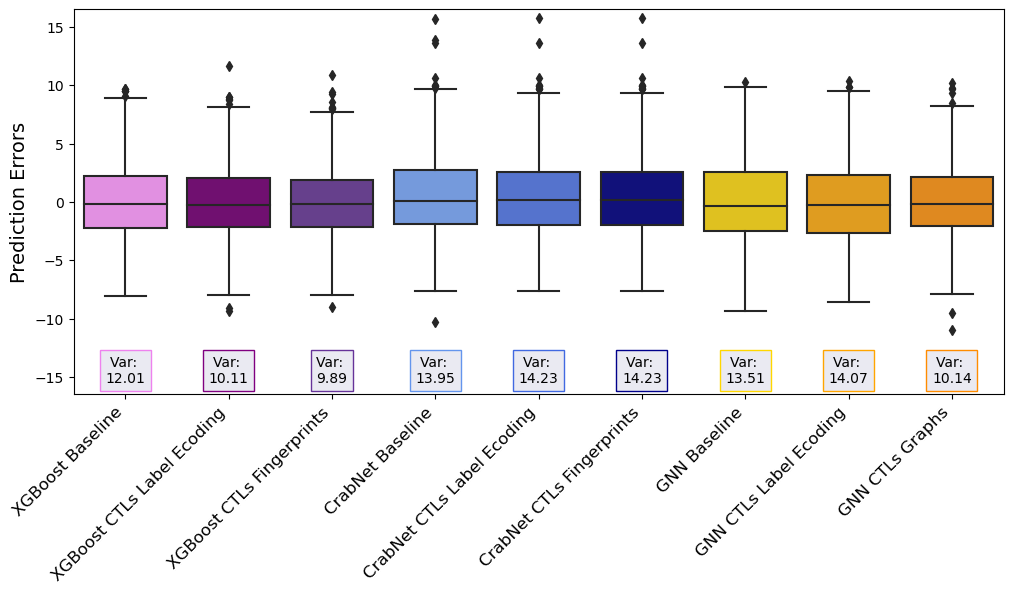

In [9]:
labels = [
    'XGBoost Baseline',
    'XGBoost CTLs Label Ecoding',
    'XGBoost CTLs Fingerprints',
    'CrabNet Baseline',
    'CrabNet CTLs Label Ecoding',
    'CrabNet CTLs Fingerprints',
    'GNN Baseline',
    'GNN CTLs Label Ecoding',
    'GNN CTLs Graphs'
]

colors = [
    "violet",
    "purple",
    "rebeccapurple",
    "cornflowerblue",
    "royalblue",
    "darkblue",
    "gold",
    "orange",
    "darkorange"
]

variances = [np.var(dataset, ddof=1) for dataset in datasets]
    

# Create a DataFrame for plotting
df = pd.DataFrame({
    'errors': [value for dataset in datasets for value in dataset],
    'model_level': [label for label, dataset in zip(labels, datasets) for _ in dataset]
})

# Create the boxplot
plt.figure(figsize=(12, 5))
boxplot = sns.boxplot(x='model_level', y='errors', data=df, palette=dict(zip(labels, colors)))

for i, var in enumerate(variances):
    plt.text(i, -15.5, f'Var: \n{var:.2f}',
             horizontalalignment='center',
             size='medium',
             color='black',
             bbox=dict(facecolor='#EAEAF2',
                       edgecolor=colors[i],
                       pad=4))

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.title('')
plt.xlabel('')
plt.ylim(-16.5,16.5)
plt.ylabel('Prediction Errors', fontsize=14)
plt.show()

## Normality

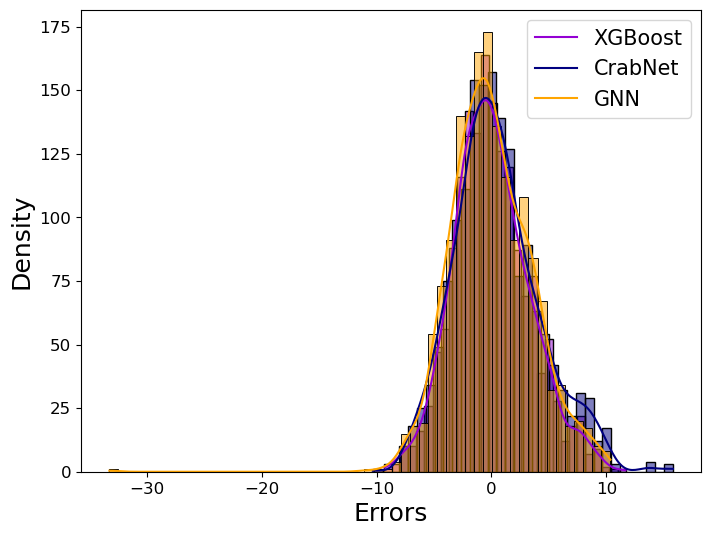

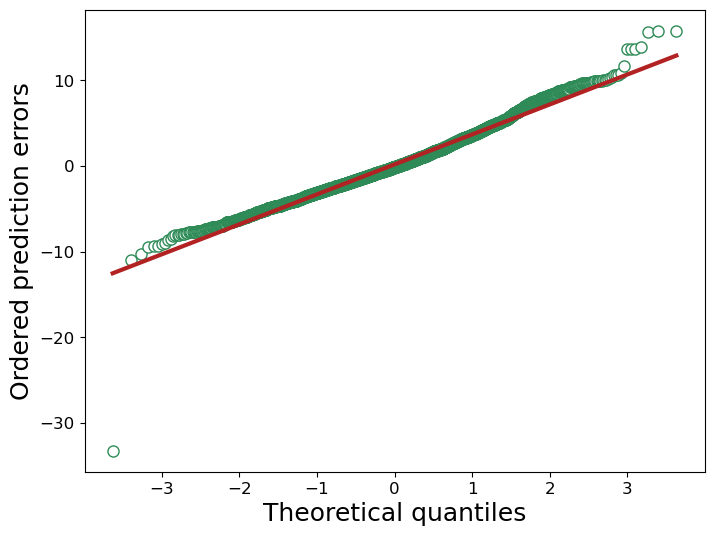

Shapiro-Wilk test statistic: 0.9817430973052979
Shapiro-Wilk p-value: 1.2707942746289612e-24
Kolmogorov-Smirnov statistic: 0.2629656408132365
Kolmogorov-Smirnov p-value: 1.0474015041771812e-298


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.figure(figsize=(8, 6))
sns.histplot(comp_df[comp_df['model'] == 'xgboost']['errors'], kde=True, label='xgboost', color="darkviolet")
sns.histplot(comp_df[comp_df['model'] == 'crabnet']['errors'], kde=True, label='crabnet', color="navy")
sns.histplot(comp_df[comp_df['model'] == 'gnn']['errors'], kde=True, label='gnn', color="orange")

plt.legend(labels =["XGBoost", "CrabNet", "GNN"], fontsize = 15)
plt.title('')
plt.xlabel('Errors', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
stats.probplot(comp_df['errors'], plot=plt)
#ax.get_lines()[0].set_marker('p')
ax.get_lines()[0].set_markerfacecolor('white')
ax.get_lines()[0].set_markeredgecolor('seagreen')
ax.get_lines()[0].set_markersize(8)
ax.get_lines()[1].set_color("firebrick")
ax.get_lines()[1].set_linewidth(3)
ax.set_ylabel("Ordered prediction errors", fontsize=18)
ax.set_xlabel("Theoretical quantiles", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.title('')
plt.show()

# The following tests are just for good measure, the visual inspection suffices
# and the tests are over-reactive with this amount of observations
# Shapiro-Wilk
shapiro_test = stats.shapiro(comp_df['errors'])
print("Shapiro-Wilk test statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

# Kolmogorov-Smirnov test
ks_statistic, p_value = stats.kstest(comp_df['errors'], 'norm')

print("Kolmogorov-Smirnov statistic:", ks_statistic)
print("Kolmogorov-Smirnov p-value:", p_value)

# Normality of error differences

In [11]:
# Between GNN & XGBoost (full)
df_e_diffs = pd. DataFrame()
df_e_diffs['xgb_gnn'] = abs(xgb_full['errors'])-abs(gnn_full['errors'])
df_e_diffs['xgb_crabnet'] = abs(xgb_full['errors'])-abs(crabnet_full['errors'])
df_e_diffs['gnn_crabnet'] = abs(gnn_full['errors'])-abs(crabnet_full['errors'])
df_e_diffs['gnn_full_abs'] = abs(gnn_full['errors'])-abs(gnn_abs['errors'])
df_e_diffs['xgb_full_abs'] = abs(xgb_full['errors'])-abs(xgb_abs['errors'])
df_e_diffs['crabnet_full_abs'] = abs(crabnet_full['errors'])-abs(crabnet_abs['errors'])

<Axes: xlabel='xgb_gnn', ylabel='Count'>

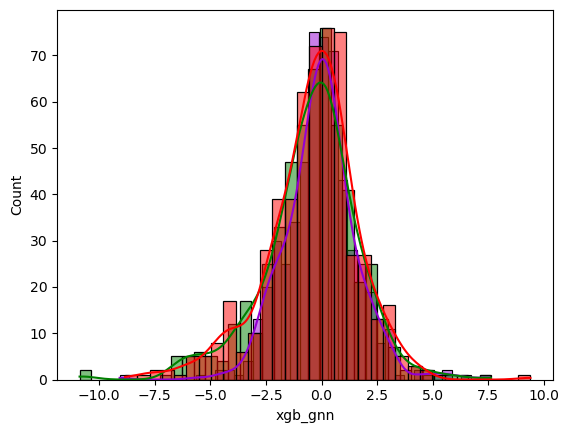

In [12]:
sns.histplot(df_e_diffs['xgb_gnn'], kde=True, label='xgboost vs gnn', color="darkviolet")
sns.histplot(df_e_diffs['xgb_crabnet'], kde=True, label='xgboost vs crabnet', color="green")
sns.histplot(df_e_diffs['gnn_crabnet'], kde=True, color="red")

# XGBoost VS GNN (error differences)

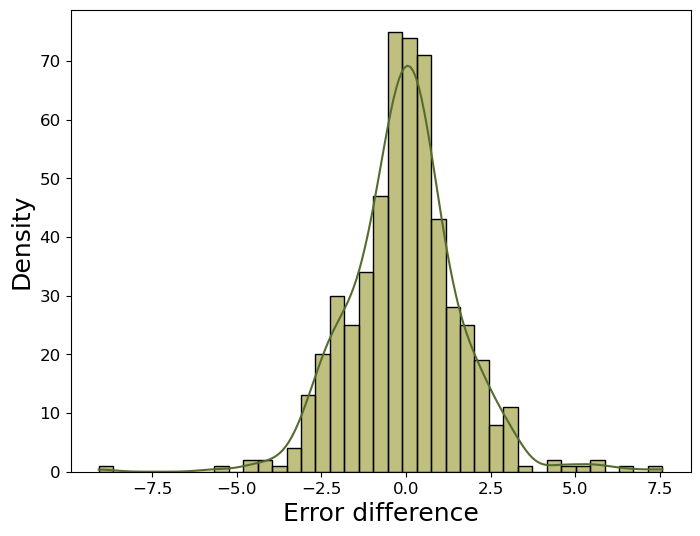

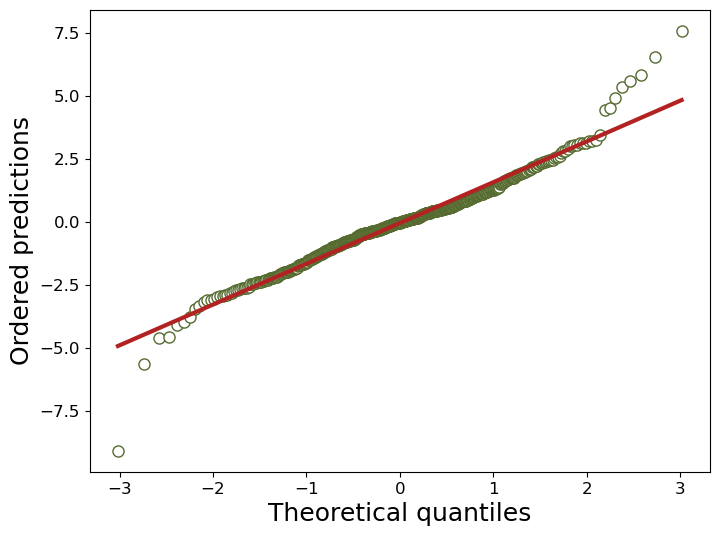

Shapiro-Wilk test statistic: 0.9662766456604004
Shapiro-Wilk p-value: 7.737041007871426e-10
Kolmogorov-Smirnov statistic: 0.10803859699939689
Kolmogorov-Smirnov p-value: 5.653964420259817e-06
XGboost - absorber_only vs full. t-test. t: -0.8551912118372617, p: 0.3928231686850401
XGboost - absorber_only vs full. Wilcoxon. W: 72328.0, p: 0.6777310671314236


In [13]:
#x = np.linspace(min(df_e_diffs['xgb_gnn']), max(df_e_diffs['xgb_gnn']), 100)
#y = stats.norm.pdf(x, np.mean(df_e_diffs['xgb_gnn']), np.std(df_e_diffs['xgb_gnn']))


plt.figure(figsize=(8, 6))
hist_plot = sns.histplot(df_e_diffs['xgb_gnn'], kde=True, label='XGBoost & GNN', color="olive")
hist_plot.lines[0].set_color('darkolivegreen')
#y = y * 333
#plt.plot(x, y, color='firebrick', linestyle='--', label='Gaussian Distribution')

plt.title('')
plt.xlabel('Error difference', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
stats.probplot(df_e_diffs['xgb_gnn'], plot=plt)
#ax.get_lines()[0].set_marker('p')
ax.get_lines()[0].set_markerfacecolor('white')
ax.get_lines()[0].set_markeredgecolor('darkolivegreen')
ax.get_lines()[0].set_markersize(8)
ax.get_lines()[1].set_color("firebrick")
ax.get_lines()[1].set_linewidth(3)
ax.set_ylabel("Ordered predictions", fontsize=18)
ax.set_xlabel("Theoretical quantiles", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.title('')
plt.show()

# The following tests are just for good measure, the visual inspection suffices
# and the tests are over-reactive with this amount of observations
# Shapiro-Wilk
shapiro_test = stats.shapiro(df_e_diffs['xgb_gnn'])
print("Shapiro-Wilk test statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

# Kolmogorov-Smirnov test
ks_statistic, p_value = stats.kstest(df_e_diffs['xgb_gnn'], 'norm')

print("Kolmogorov-Smirnov statistic:", ks_statistic)
print("Kolmogorov-Smirnov p-value:", p_value)

xgboost_gnn_full_t, xgboost_gnn_full_p = stats.ttest_rel(xgb_full['errors'], gnn_full['errors'])
print(f"XGboost - absorber_only vs full. t-test. t: {xgboost_gnn_full_t}, p: {xgboost_gnn_full_p}")

xgboost_gnn_full_t, xgboost_gnn_full_p = stats.wilcoxon(xgb_full['errors'], gnn_full['errors'])
print(f"XGboost - absorber_only vs full. Wilcoxon. W: {xgboost_gnn_full_t}, p: {xgboost_gnn_full_p}")

In [14]:
df_e_diffs[df_e_diffs['xgb_gnn'] == min(df_e_diffs['xgb_gnn'])]

,xgb_gnn,xgb_crabnet,gnn_crabnet,gnn_full_abs,xgb_full_abs,crabnet_full_abs
114,-9.081561,0.317198,9.398759,8.900053,0.113758,-0.142355


# GNN full vs baseline (error differences)

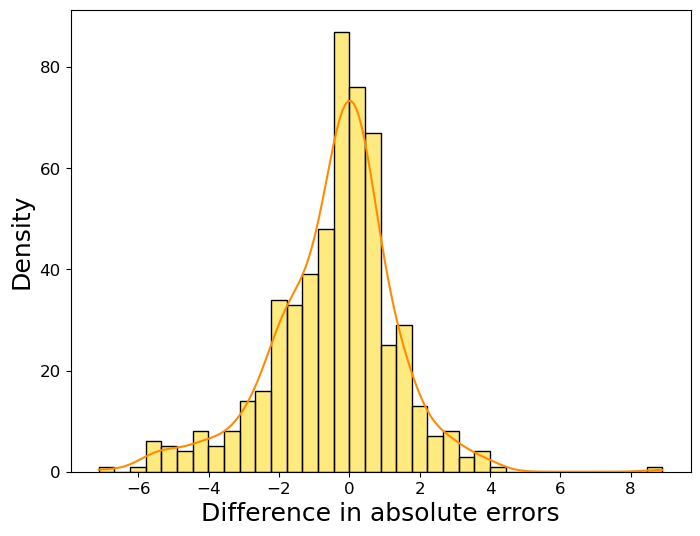

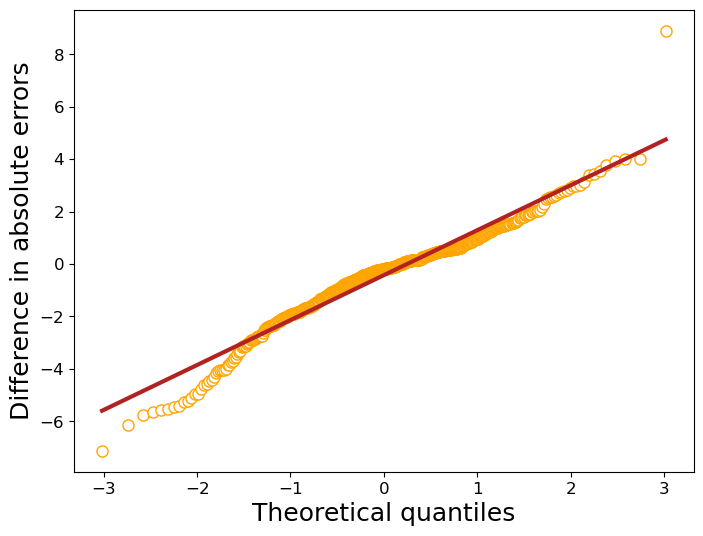

Shapiro-Wilk test statistic: 0.9583642482757568
Shapiro-Wilk p-value: 2.918031441478952e-11
Kolmogorov-Smirnov statistic: 0.16668739059180634
Kolmogorov-Smirnov p-value: 1.1781357253249572e-13
GNN full vs baseline. t-test. t: -5.655864024228486, p: 2.512253906694267e-08
GNN full vs baseline. Wilcoxon. W: 55765.0, p: 7.660947251975761e-07


In [15]:
#x = np.linspace(min(df_e_diffs['xgb_gnn']), max(df_e_diffs['xgb_gnn']), 100)
#y = stats.norm.pdf(x, np.mean(df_e_diffs['xgb_gnn']), np.std(df_e_diffs['xgb_gnn']))


plt.figure(figsize=(8, 6))
hist_plot = sns.histplot(df_e_diffs['gnn_full_abs'], kde=True, label='GNN full vs baseline', color="gold")
hist_plot.lines[0].set_color('darkorange')
#y = y * 333
#plt.plot(x, y, color='firebrick', linestyle='--', label='Gaussian Distribution')

plt.title('')
plt.xlabel('Difference in absolute errors', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
stats.probplot(df_e_diffs['gnn_full_abs'], plot=plt)
#ax.get_lines()[0].set_marker('p')
ax.get_lines()[0].set_markerfacecolor('white')
ax.get_lines()[0].set_markeredgecolor('orange')
ax.get_lines()[0].set_markersize(8)
ax.get_lines()[1].set_color("firebrick")
ax.get_lines()[1].set_linewidth(3)
ax.set_ylabel("Difference in absolute errors", fontsize=18)
ax.set_xlabel("Theoretical quantiles", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.title('')
plt.show()

# The following tests are just for good measure, the visual inspection suffices
# and the tests are over-reactive with this amount of observations
# Shapiro-Wilk
shapiro_test = stats.shapiro(df_e_diffs['gnn_full_abs'])
print("Shapiro-Wilk test statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

# Kolmogorov-Smirnov test
ks_statistic, p_value = stats.kstest(df_e_diffs['gnn_full_abs'], 'norm')

print("Kolmogorov-Smirnov statistic:", ks_statistic)
print("Kolmogorov-Smirnov p-value:", p_value)

gnn_full_abs_t, gnn_full_abs_p = stats.ttest_rel(abs(gnn_full['errors']), abs(gnn_abs['errors']))
print(f"GNN full vs baseline. t-test. t: {gnn_full_abs_t}, p: {gnn_full_abs_p}")

gnn_full_abs_t, gnn_full_abs_p = stats.wilcoxon(abs(gnn_full['errors']), abs(gnn_abs['errors']))
print(f"GNN full vs baseline. Wilcoxon. W: {gnn_full_abs_t}, p: {gnn_full_abs_p}")

# CrabNet full vs baseline

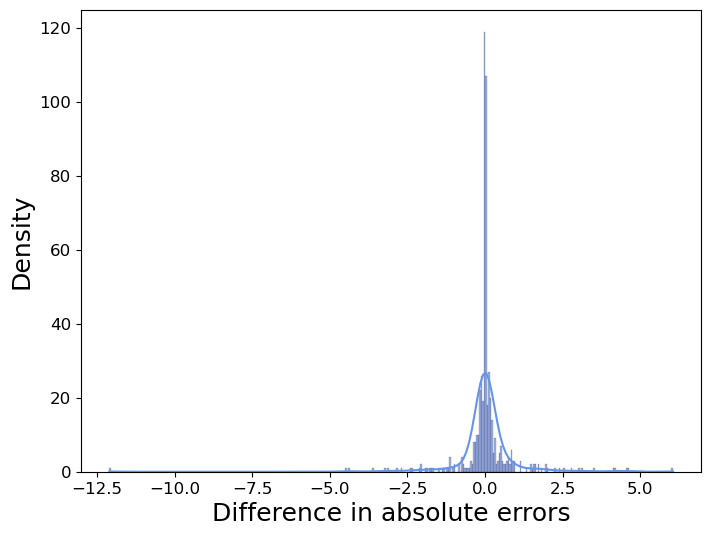

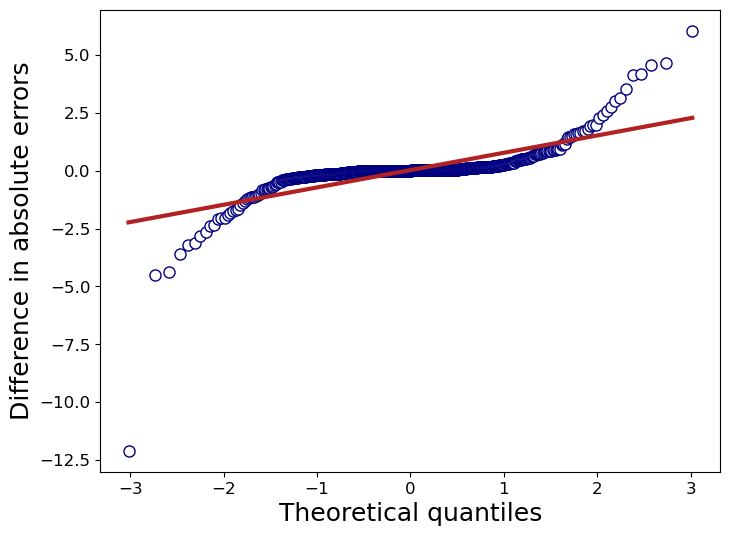

Shapiro-Wilk test statistic: 0.5699291229248047
Shapiro-Wilk p-value: 1.9479865346769814e-34
Kolmogorov-Smirnov statistic: 0.27137865204300005
Kolmogorov-Smirnov p-value: 8.102541881228816e-36
CrabNet full vs baseline. t-test. t: 0.6406410953412103, p: 0.5220266501564435
CrabNet full vs baseline. Wilcoxon. W: 69796.5, p: 0.26638522081773286


In [16]:
#x = np.linspace(min(df_e_diffs['xgb_gnn']), max(df_e_diffs['xgb_gnn']), 100)
#y = stats.norm.pdf(x, np.mean(df_e_diffs['xgb_gnn']), np.std(df_e_diffs['xgb_gnn']))


plt.figure(figsize=(8, 6))
hist_plot = sns.histplot(df_e_diffs['crabnet_full_abs'], kde=True, label='CrabNet full vs baseline', color="royalblue")
hist_plot.lines[0].set_color('cornflowerblue')
#y = y * 333
#plt.plot(x, y, color='firebrick', linestyle='--', label='Gaussian Distribution')


plt.title('')
plt.xlabel('Difference in absolute errors', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
stats.probplot(df_e_diffs['crabnet_full_abs'], plot=plt)
#ax.get_lines()[0].set_marker('p')
ax.get_lines()[0].set_markerfacecolor('white')
ax.get_lines()[0].set_markeredgecolor('navy')
ax.get_lines()[0].set_markersize(8)
ax.get_lines()[1].set_color("firebrick")
ax.get_lines()[1].set_linewidth(3)
ax.set_ylabel("Difference in absolute errors", fontsize=18)
ax.set_xlabel("Theoretical quantiles", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.title('')
plt.show()

# The following tests are just for good measure, the visual inspection suffices
# and the tests are over-reactive with this amount of observations
# Shapiro-Wilk
shapiro_test = stats.shapiro(df_e_diffs['crabnet_full_abs'])
print("Shapiro-Wilk test statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

# Kolmogorov-Smirnov test
ks_statistic, p_value = stats.kstest(df_e_diffs['crabnet_full_abs'], 'norm')
print("Kolmogorov-Smirnov statistic:", ks_statistic)
print("Kolmogorov-Smirnov p-value:", p_value)

crabnet_full_abs_t, crabnet_full_abs_p = stats.ttest_rel(abs(crabnet_full['errors']), abs(crabnet_abs['errors']))
print(f"CrabNet full vs baseline. t-test. t: {crabnet_full_abs_t}, p: {crabnet_full_abs_p}")

crabnet_full_abs_t, crabnet_full_abs_p = stats.wilcoxon(abs(crabnet_full['errors']), abs(crabnet_abs['errors']))
print(f"CrabNet full vs baseline. Wilcoxon. W: {crabnet_full_abs_t}, p: {crabnet_full_abs_p}")

# XGBoost full vs. baseline (error differences)

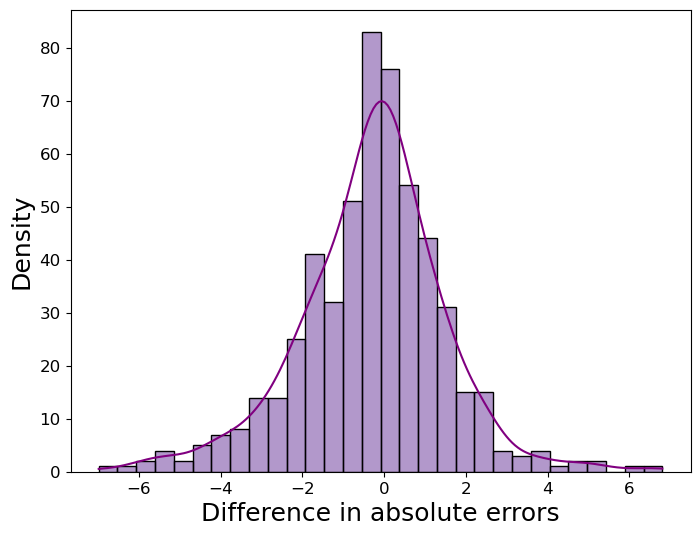

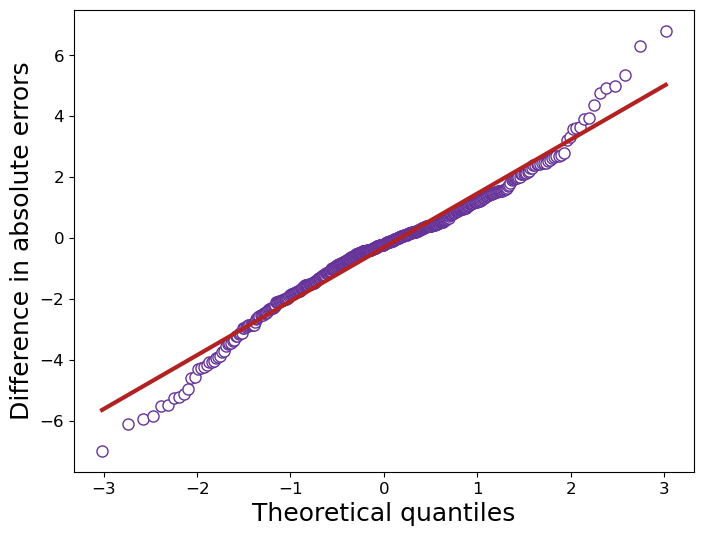

Shapiro-Wilk test statistic: 0.9741866588592529
Shapiro-Wilk p-value: 3.437131823602613e-08
Kolmogorov-Smirnov statistic: 0.1584589166536984
Kolmogorov-Smirnov p-value: 2.23934833930589e-12
XGBoost full vs baseline. t-test. t: -3.990130151844578, p: 7.511856615712317e-05
XGBoost full vs baseline. Wilcoxon. W: 60101.5, p: 0.0001711178623972842


In [17]:
#x = np.linspace(min(df_e_diffs['xgb_gnn']), max(df_e_diffs['xgb_gnn']), 100)
#y = stats.norm.pdf(x, np.mean(df_e_diffs['xgb_gnn']), np.std(df_e_diffs['xgb_gnn']))


plt.figure(figsize=(8, 6))
hist_plot = sns.histplot(df_e_diffs['xgb_full_abs'], kde=True, label='XGBoost full vs baseline', color="rebeccapurple")
hist_plot.lines[0].set_color('purple')
#y = y * 333
#plt.plot(x, y, color='firebrick', linestyle='--', label='Gaussian Distribution')


plt.title('')
plt.xlabel('Difference in absolute errors', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
stats.probplot(df_e_diffs['xgb_full_abs'], plot=plt)
#ax.get_lines()[0].set_marker('p')
ax.get_lines()[0].set_markerfacecolor('white')
ax.get_lines()[0].set_markeredgecolor('rebeccapurple')
ax.get_lines()[0].set_markersize(8)
ax.get_lines()[1].set_color("firebrick")
ax.get_lines()[1].set_linewidth(3)
ax.set_ylabel("Difference in absolute errors", fontsize=18)
ax.set_xlabel("Theoretical quantiles", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.title('')
plt.show()

# The following tests are just for good measure, the visual inspection suffices
# and the tests are over-reactive with this amount of observations
# Shapiro-Wilk
shapiro_test = stats.shapiro(df_e_diffs['xgb_full_abs'])
print("Shapiro-Wilk test statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

# Kolmogorov-Smirnov test
ks_statistic, p_value = stats.kstest(df_e_diffs['xgb_full_abs'], 'norm')

print("Kolmogorov-Smirnov statistic:", ks_statistic)
print("Kolmogorov-Smirnov p-value:", p_value)

xgb_full_abs_t, xgb_full_abs_p = stats.ttest_rel(abs(xgb_full['errors']), abs(xgb_abs['errors']))
print(f"XGBoost full vs baseline. t-test. t: {xgb_full_abs_t}, p: {xgb_full_abs_p}")

xgb_full_abs_t, xgb_full_abs_p = stats.wilcoxon(abs(xgb_full['errors']), abs(xgb_abs['errors']))
print(f"XGBoost full vs baseline. Wilcoxon. W: {xgb_full_abs_t}, p: {xgb_full_abs_p}")

# ANOVA

In [18]:
# ANOVA with no exclusions
comp_df['errors'] = abs(comp_df['errors'])
model = ols('errors ~ C(model) + C(level) + C(model):C(level)', data=comp_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                         sum_sq      df         F    PR(>F)
C(model)              97.747855     2.0  9.845690  0.000054
C(level)              44.778011     2.0  4.510282  0.011041
C(model):C(level)     39.574202     4.0  1.993063  0.092781
Residual           24214.354116  4878.0       NaN       NaN


# Prediction plots

In [19]:
plot_df = pd.DataFrame()
plot_df['model'] = ['xgboost']*1629 + ['crabnet']*1629 + ['gnn']*1629
plot_df['level'] = ['abs_only']*543 + ['labels']*543 + ['full']*543 + ['abs_only']*543 + ['labels']*543 + ['full']*543 + ['abs_only']*543 + ['labels']*543 + ['full']*543

plot_df['predicted'] = pd.concat([
    xgb_abs['predicted'],
    xgb_labels['predicted'],
    xgb_full['predicted'],
    crabnet_abs['predicted'],
    crabnet_labels['predicted'],
    crabnet_full['predicted'],
    gnn_abs['predicted'],
    gnn_labels['predicted'],
    gnn_full['predicted']
], ignore_index=True)

plot_df['true_values'] = pd.concat([
    xgb_abs['true_values'],
    xgb_labels['true_values'],
    xgb_full['true_values'],
    crabnet_abs['true_values'],
    crabnet_labels['true_values'],
    crabnet_full['true_values'],
    gnn_abs['true_values'],
    gnn_labels['true_values'],
    gnn_full['true_values']
], ignore_index=True)

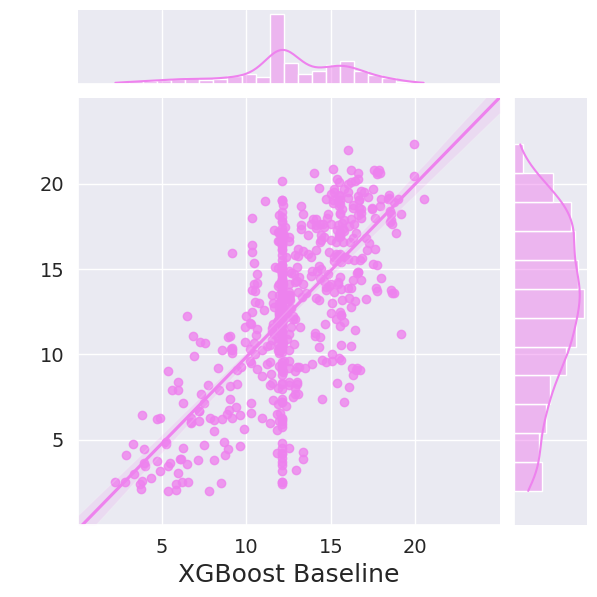

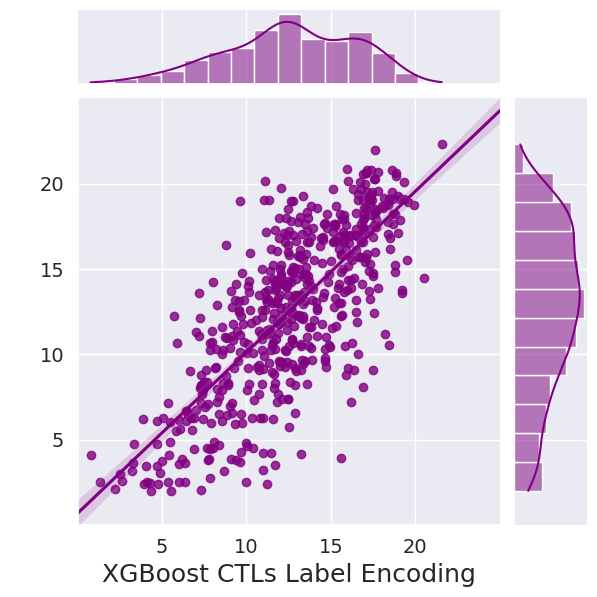

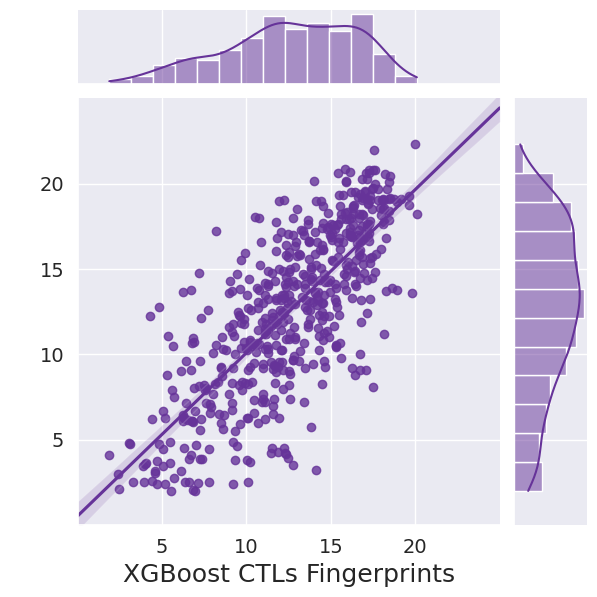

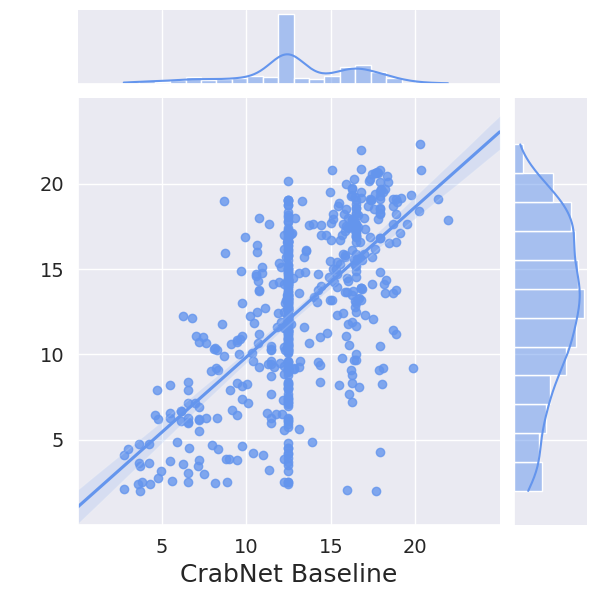

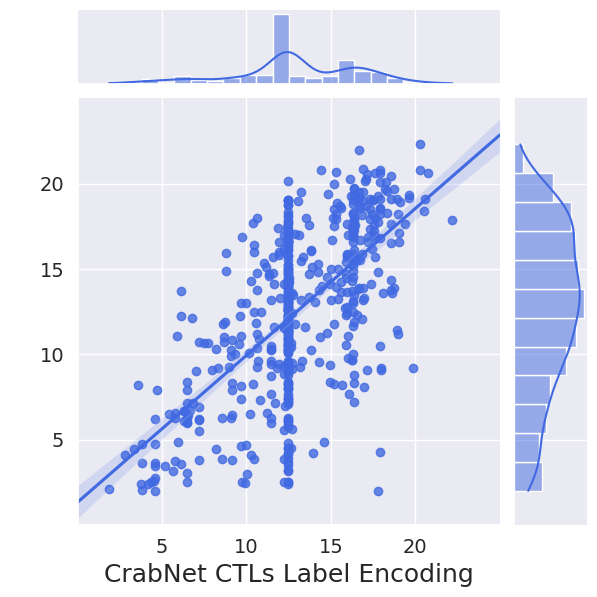

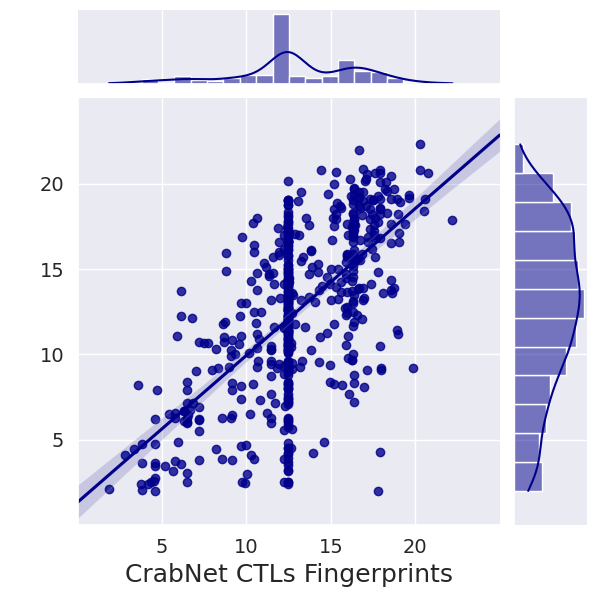

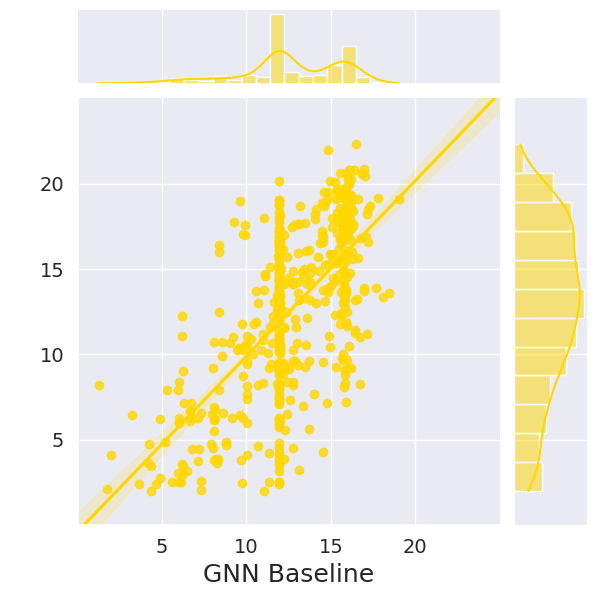

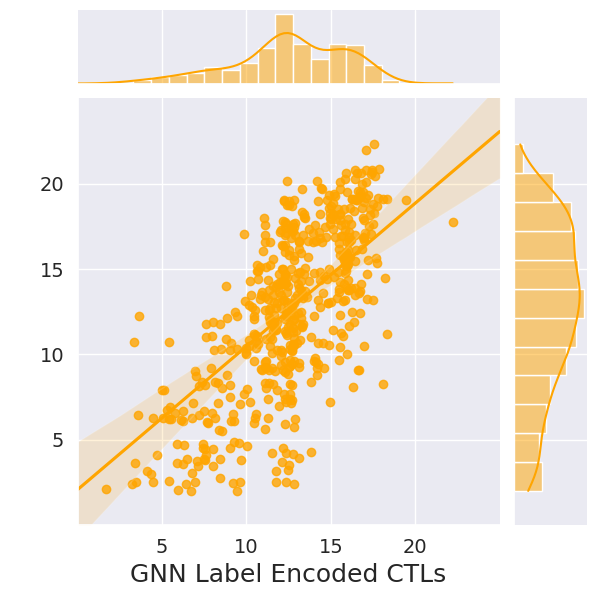

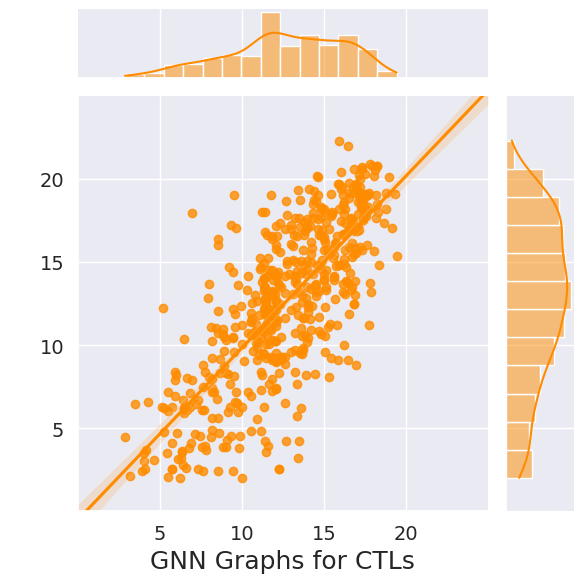

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming plot_df is your DataFrame

# Create a figure with 3 rows and 3 columns
#fig, axes = plt.subplots(3, 3, figsize=(10, 10))
#fig.supxlabel("Predictions", fontsize=16)
#fig.supylabel("True values", fontsize=16)



xgboost_titles = {0: "XGBoost Baseline",
                  1: "XGBoost CTLs Label Encoding",
                  2: "XGBoost CTLs Fingerprints"}

crabnet_titles = {0: "CrabNet Baseline",
                  1: "CrabNet CTLs Label Encoding",
                  2: "CrabNet CTLs Fingerprints"}

gnn_titles = {0: "GNN Baseline",
              1: "GNN Label Encoded CTLs",
              2: "GNN Graphs for CTLs"}

overtitles = {0: xgboost_titles,
              1: crabnet_titles,
              2: gnn_titles}



xgboost_colors = {0: "violet",
                  1: "purple",
                  2: "rebeccapurple"}

crabnet_colors = {0: "cornflowerblue",
                  1: "royalblue",
                  2: "darkblue"}

gnn_colors = {0: "gold",
              1: "orange",
              2: "darkorange"}

overcolors = {0: xgboost_colors,
              1: crabnet_colors,
              2: gnn_colors}

sns.set_theme()

# Iterate over unique combinations of model and level
for i, model in enumerate(plot_df['model'].unique()):
    titles=overtitles[i]
    colors=overcolors[i]
    for j, level in enumerate(plot_df['level'].unique()):
        data = plot_df[(plot_df['model'] == model) & (plot_df['level'] == level)]
        g=sns.jointplot(x="predicted", y="true_values", data=data,
                  kind="reg", truncate=False,
                  xlim=(0, 25), ylim=(0, 25),
                  color=colors[j])

        g.set_axis_labels(f'{titles[j]}', ' ', fontsize=18)
        #g.fig.suptitle(f"{titles[j]}", fontsize=16)
        g.ax_joint.collections[0].set_alpha(0.8)
        #g.fig.tight_layout()
        #g.fig.subplots_adjust(top=0.90)
        g.ax_joint.set_xticks(ticks=[5, 10, 15, 20], labels=["5", "10", "15", "20"], fontsize=14)
        g.ax_joint.set_yticks([5, 10, 15, 20], labels=["5", "10", "15", "20"], fontsize=14)
        

# Adjust layout
plt.tight_layout()
plt.show()


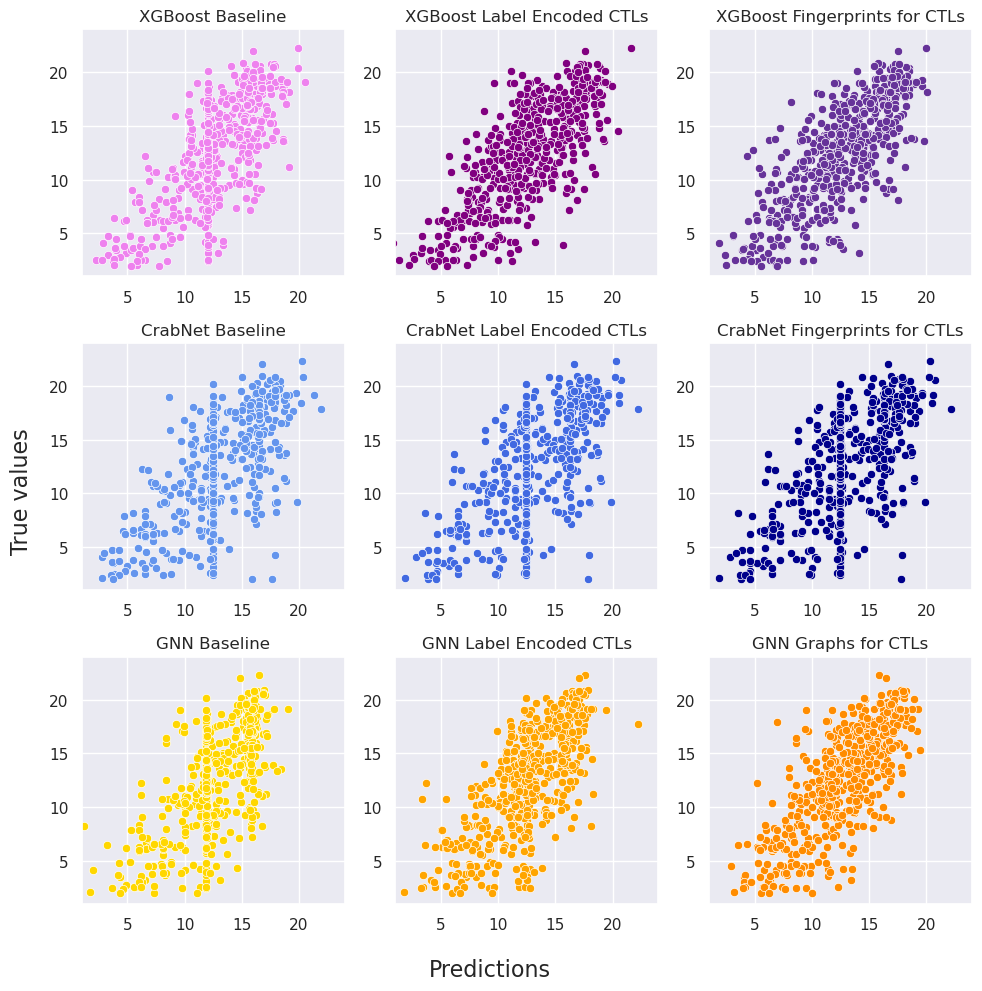

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming plot_df is your DataFrame

# Create a figure with 3 rows and 3 columns
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.supxlabel("Predictions", fontsize=16)
fig.supylabel("True values", fontsize=16)



xgboost_titles = {0: "XGBoost Baseline",
                  1: "XGBoost Label Encoded CTLs",
                  2: "XGBoost Fingerprints for CTLs"}

crabnet_titles = {0: "CrabNet Baseline",
                  1: "CrabNet Label Encoded CTLs",
                  2: "CrabNet Fingerprints for CTLs"}

gnn_titles = {0: "GNN Baseline",
              1: "GNN Label Encoded CTLs",
              2: "GNN Graphs for CTLs"}

overtitles = {0: xgboost_titles,
              1: crabnet_titles,
              2: gnn_titles}



xgboost_colors = {0: "violet",
                  1: "purple",
                  2: "rebeccapurple"}

crabnet_colors = {0: "cornflowerblue",
                  1: "royalblue",
                  2: "darkblue"}

gnn_colors = {0: "gold",
              1: "orange",
              2: "darkorange"}

overcolors = {0: xgboost_colors,
              1: crabnet_colors,
              2: gnn_colors}


# Iterate over unique combinations of model and level
for i, model in enumerate(plot_df['model'].unique()):
    titles=overtitles[i]
    colors=overcolors[i]
    for j, level in enumerate(plot_df['level'].unique()):
        data = plot_df[(plot_df['model'] == model) & (plot_df['level'] == level)]
        sns.scatterplot(x='predicted', y='true_values', data=data, ax=axes[i, j], color=colors[j])
        axes[i, j].set_ylabel('')
        axes[i, j].set_xlabel('')
        axes[i, j].set_xlim(1,24)
        axes[i, j].set_ylim(1,24)
        axes[i, j].set_title(f"{titles[j]}")
        

# Adjust layout
plt.tight_layout()
plt.show()
